# Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Historical Data for Modeling (Exploring)

In [ ]:
modeling_df = pd.read_csv('/content/drive/MyDrive/1976-2020-president.csv')
modeling_df

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER


Group by Presidential Winner per State by Year

In [ ]:
# Group by year and state, and find the candidate with the maximum votes in each group
winners = modeling_df.loc[modeling_df.groupby(['year', 'state'])['candidatevotes'].idxmax()]

# Create the table with desired columns
winner_table = winners[['year', 'state', 'candidate', 'party_detailed']]

# Display the table
print(winner_table)

      year          state            candidate party_detailed
0     1976        ALABAMA        CARTER, JIMMY       DEMOCRAT
7     1976         ALASKA         FORD, GERALD     REPUBLICAN
11    1976        ARIZONA         FORD, GERALD     REPUBLICAN
19    1976       ARKANSAS        CARTER, JIMMY       DEMOCRAT
23    1976     CALIFORNIA         FORD, GERALD     REPUBLICAN
...    ...            ...                  ...            ...
4252  2020       VIRGINIA  BIDEN, JOSEPH R. JR       DEMOCRAT
4256  2020     WASHINGTON  BIDEN, JOSEPH R. JR       DEMOCRAT
4264  2020  WEST VIRGINIA     TRUMP, DONALD J.     REPUBLICAN
4267  2020      WISCONSIN  BIDEN, JOSEPH R. JR       DEMOCRAT
4281  2020        WYOMING     TRUMP, DONALD J.     REPUBLICAN

[612 rows x 4 columns]


# Preprocessing

Adding a Column for State Number (Assigned by Order of Admission into the Union) - Preprocessing the state column

In [ ]:
modeling_df = modeling_df.copy()

In [ ]:
print(modeling_df['state_po'].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [ ]:
# Mapping state abbreviations based on order of admission into the Union
state_admission_order = {
    'DE': 1, 'PA': 2, 'NJ': 3, 'GA': 4, 'CT': 5,
    'MA': 6, 'MD': 7, 'SC': 8, 'NH': 9, 'VA': 10,
    'NY': 11, 'NC': 12, 'RI': 13, 'VT': 14, 'KY': 15,
    'TN': 16, 'OH': 17, 'LA': 18, 'IN': 19, 'MS': 20,
    'IL': 21, 'AL': 22, 'ME': 23, 'MO': 24, 'AR': 25,
    'MI': 26, 'FL': 27, 'TX': 28, 'IA': 29, 'WI': 30,
    'CA': 31, 'MN': 32, 'OR': 33, 'KS': 34, 'WV': 35,
    'NV': 36, 'NE': 37, 'CO': 38, 'ND': 39, 'SD': 40,
    'MT': 41, 'WA': 42, 'ID': 43, 'WY': 44, 'UT': 45,
    'OK': 46, 'NM': 47, 'AZ': 48, 'AK': 49, 'HI': 50
}

In [ ]:
# Map state abbreviations to their order of admission
modeling_df['state_num'] = modeling_df['state_po'].map(state_admission_order)

# Check for any missing values in the new column
missing_states = modeling_df[modeling_df['state_num'].isna()]['state_po'].unique()
print(f'Missing state abbreviations: {missing_states}')

Missing state abbreviations: ['DC']


In [ ]:
modeling_df = modeling_df.dropna(subset=['state_num'])

Preprocessing the party_simplified column - Using Label Encoder


In [ ]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()
modeling_df.loc[:, 'party_encoded'] = label_encoder.fit_transform(modeling_df['party_simplified'])

# Verify the new column
print(modeling_df[['party_simplified', 'party_encoded']].head())


  party_simplified  party_encoded
0         DEMOCRAT              0
1       REPUBLICAN              3
2            OTHER              2
3            OTHER              2
4            OTHER              2


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Convert relevant columns to appropriate data types
modeling_df.loc[:, 'year'] = modeling_df['year'].astype(int)
modeling_df.loc[:, 'candidatevotes'] = modeling_df['candidatevotes'].astype(int)
modeling_df.loc[:, 'totalvotes'] = modeling_df['totalvotes'].astype(int)

# Create a new column for the vote percentage
modeling_df.loc[:, 'vote_percentage'] = modeling_df['candidatevotes'] / modeling_df['totalvotes'] * 100

# Create a column for the winning candidate in each state for each year
modeling_df.loc[:, 'winner'] = modeling_df.groupby(['year', 'state'])['candidatevotes'].transform(max) == modeling_df['candidatevotes']

# Verify the changes
modeling_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num,party_encoded,vote_percentage,winner
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,22.0,0,55.727269,True
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,22.0,3,42.614871,False
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER,22.0,2,0.777613,False
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER,22.0,2,0.563808,False
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER,22.0,2,0.165194,False


# Feature Engineering

In [ ]:
parties = list(modeling_df.party_simplified.unique())
df_year_party = pd.DataFrame(columns=["year"] + parties)

for year in modeling_df.year.unique():
    row = {"year": year}
    for party in parties:
        row[party] = modeling_df[(modeling_df.year == year) & (modeling_df.party_simplified == party)].candidatevotes.sum()
    df_year_party = pd.concat([df_year_party, pd.DataFrame([row])], ignore_index=True)

df_year_party["votes_casted"] = df_year_party[parties].sum(axis=1)

df_year_party = df_year_party.astype(np.uint32)
df_year_party.year = df_year_party.year.astype(np.uint16)

df_year_party.set_index('year', inplace=True)
df_year_party

,DEMOCRAT,REPUBLICAN,OTHER,LIBERTARIAN,votes_casted
year,,,,,
1976,40542628,38843020,1951240,95626,81432514
1980,35350717,43619326,6486622,866297,86322962
1984,37269405,54137820,809423,226925,92443573
1988,41557272,48615050,812472,409154,91393948
1992,44664128,38778215,20649484,280381,104372208
1996,47137131,38986358,9615840,464763,96204092
2000,50658657,50293299,4060396,379736,105392088
2004,58691591,61851455,1210012,368806,122121864
2008,69093046,59596468,1953430,510456,131153400


In [ ]:
def line_plot(data_dict: dict, title: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    for label, data in data_dict.items():
        sns.lineplot(data=data, label=label)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("% votes")
    plt.xticks(ticks=data.index, labels=data.index, rotation=-30)
    plt.xlim(data.index.min(), data.index.max())
    plt.legend(title='Party')
    plt.grid(True)
    plt.show()

# % of votes per party per year (out of total votes casted)
data_democrat = df_year_party.DEMOCRAT / df_year_party.votes_casted * 100
data_replublican = df_year_party.REPUBLICAN / df_year_party.votes_casted * 100
data_other = df_year_party.OTHER / df_year_party.votes_casted * 100
data_libertarian = df_year_party.LIBERTARIAN / df_year_party.votes_casted * 100

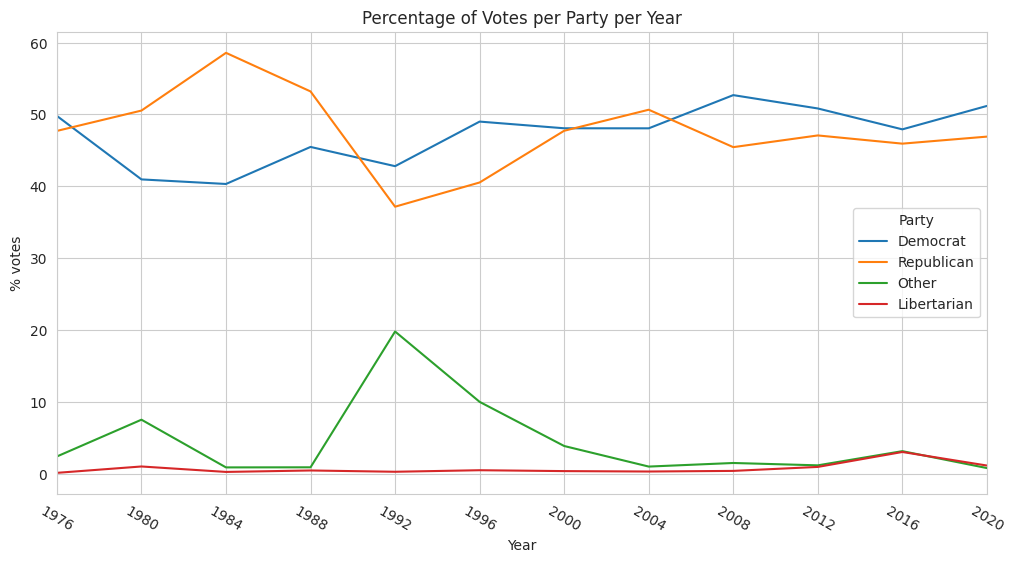

In [ ]:
# Create a dictionary of data for each party
data_dict = {
    'Democrat': data_democrat,
    'Republican': data_replublican,
    'Other': data_other,
    'Libertarian': data_libertarian
}

# Call the modified line_plot function
line_plot(data_dict, 'Percentage of Votes per Party per Year')

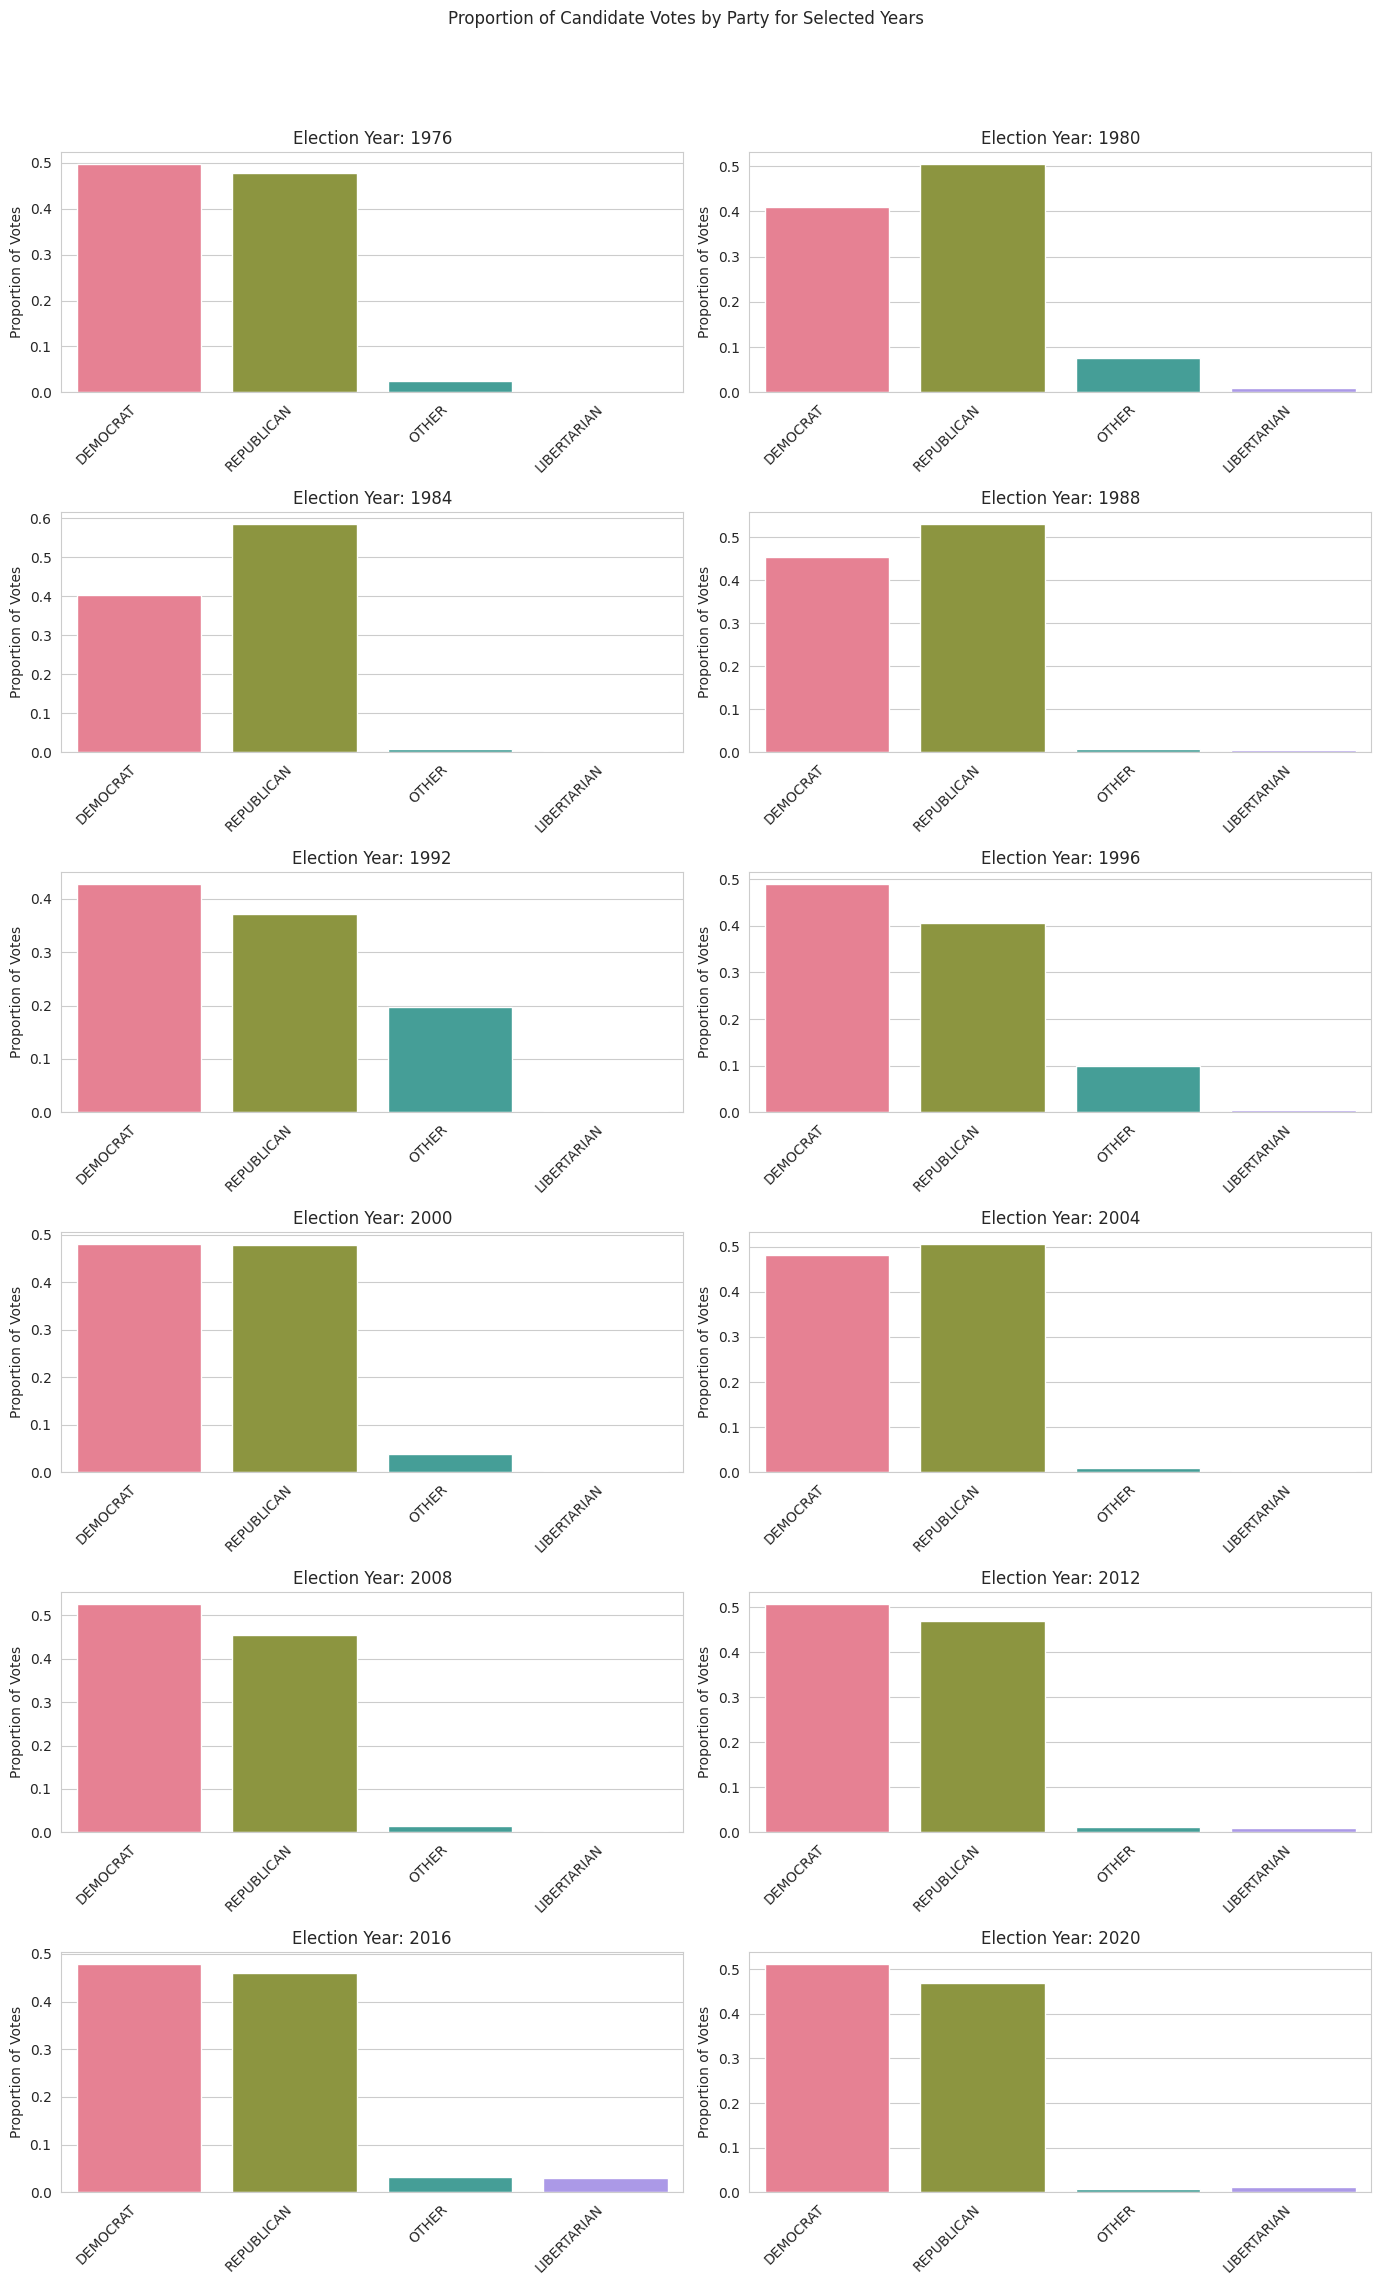

In [ ]:
def plot_vote_proportion_histograms(data_df, start_year, end_year, step):

    # Set the style
    sns.set_style("whitegrid")

    # Exclude 'votes_casted' column
    if 'votes_casted' in data_df.columns:
        data_df = data_df.drop('votes_casted', axis=1)

    palette = sns.color_palette("husl", n_colors=len(data_df.columns))

    # Select the desired election years
    selected_years = range(start_year, end_year + 1, step)
    selected_data = data_df.loc[selected_years]

    # Determine the number of rows needed (2 years per row)
    nrows = len(selected_years) // 2 + len(selected_years) % 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 4 * nrows))
    fig.suptitle("Proportion of Candidate Votes by Party for Selected Years")

    # Flatten axes for easier indexing
    axes = axes.flatten()

    # Plot histograms for each year
    for i, year in enumerate(selected_years):
        ax = axes[i]

        # Calculate proportions for the current year
        year_proportions = selected_data.loc[year] / selected_data.loc[year].sum()

        # Create a bar plot
        sns.barplot(x=year_proportions.index, y=year_proportions.values, palette=palette, ax=ax)

        ax.set_ylabel("Proportion of Votes")
        ax.set_title(f"Election Year: {year}")
        ax.set_xticklabels(year_proportions.index, rotation=45, ha='right')

        # Remove the x-axis label
        ax.set_xlabel('')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with the desired parameters
plot_vote_proportion_histograms(df_year_party, 1976, 2020, 4)

In [ ]:
# Filter the data for years 1996 to 2020
historical_data = modeling_df[(modeling_df['year'] >= 1996) & (modeling_df['year'] <= 2020)]

# Determine the winning party for each state in each election year
state_winners = historical_data.groupby(['year', 'state']).apply(
    lambda x: x.loc[x['candidatevotes'].idxmax(), 'party_simplified']
).reset_index(name='winning_party')

# Display the result
print(state_winners)

     year          state winning_party
0    1996        ALABAMA    REPUBLICAN
1    1996         ALASKA    REPUBLICAN
2    1996        ARIZONA      DEMOCRAT
3    1996       ARKANSAS      DEMOCRAT
4    1996     CALIFORNIA      DEMOCRAT
..    ...            ...           ...
345  2020       VIRGINIA      DEMOCRAT
346  2020     WASHINGTON      DEMOCRAT
347  2020  WEST VIRGINIA    REPUBLICAN
348  2020      WISCONSIN      DEMOCRAT
349  2020        WYOMING    REPUBLICAN

[350 rows x 3 columns]


Winning Party Based on Most Candidate Votes in the Last 7 Elections

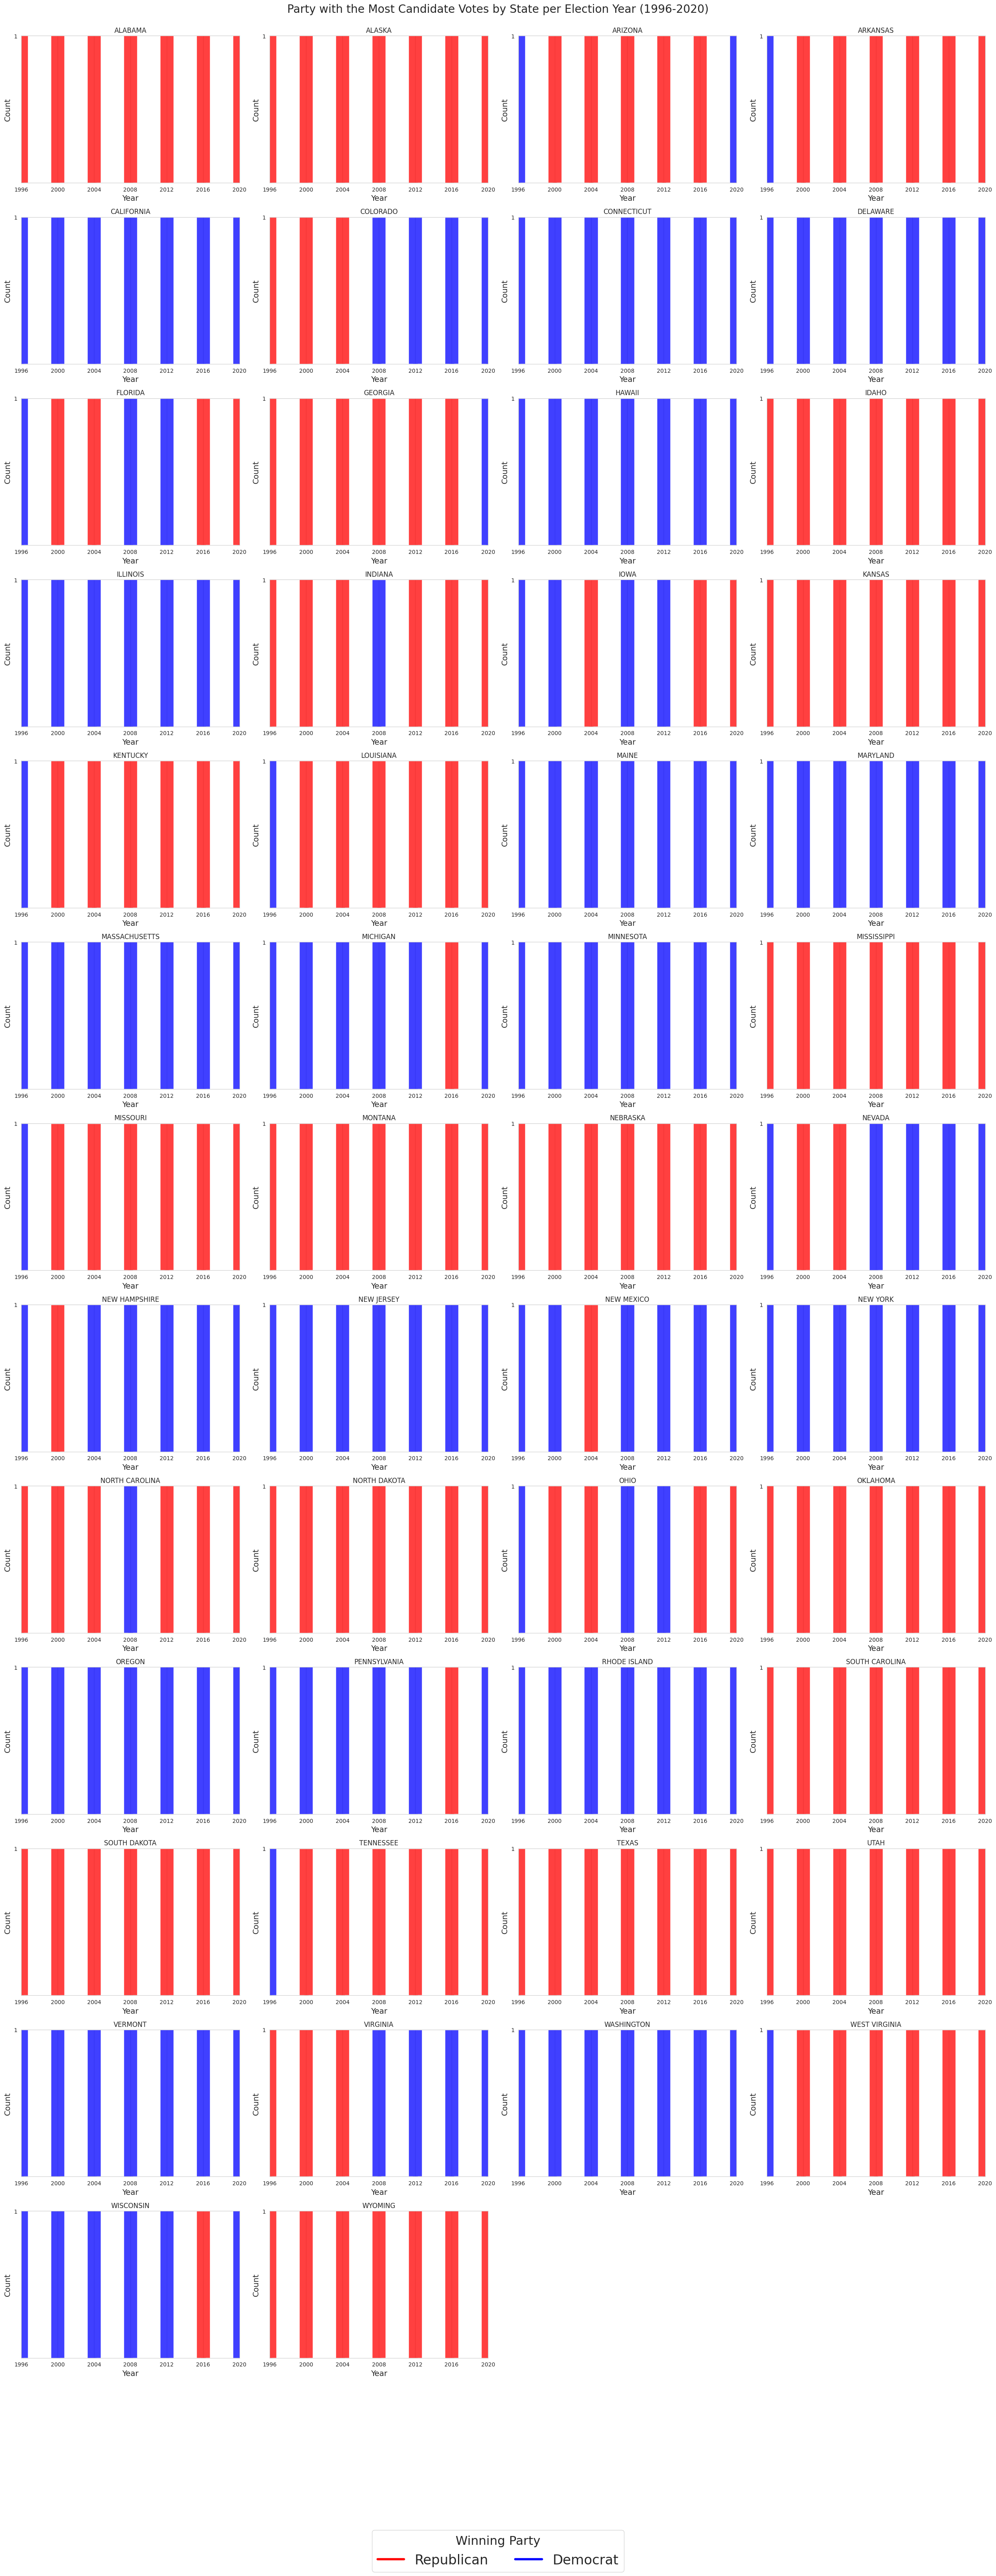

In [ ]:
# Plot settings
plt.figure(figsize=(25, 70))
states = state_winners['state'].unique()
n_states = len(states)
n_cols = 4  # Number of plots per row
n_rows = (n_states + n_cols - 1) // n_cols  # Calculate the number of rows needed
custom_palette = {"REPUBLICAN": "red", "DEMOCRAT": "blue"}

# Create subplots for each state
for i, state in enumerate(states):
    plt.subplot(n_rows, n_cols, i + 1)  # Create subplot
    sns.histplot(data=state_winners[state_winners['state'] == state],
                 x='year', hue='winning_party', multiple='stack', palette=custom_palette,
                 binwidth=8, discrete=True, shrink=1.5, legend=False)
    plt.title(state)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xlim(1996, 2020)
    plt.xticks([1996, 2000, 2004, 2008, 2012, 2016, 2020])
    plt.ylim(0, 1)  # Set y-axis limits to be from 0 to 1
    plt.yticks([1])  # Set y-axis ticks to only show '1'

# Add a title for the entire figure
plt.suptitle('Party with the Most Candidate Votes by State per Election Year (1996-2020)', fontsize=20, y=0.95)

# Create a single legend for Republican and Democrat within the main figure
handles = [plt.Line2D([0], [0], color='red', lw=4), plt.Line2D([0], [0], color='blue', lw=4)]
labels = ['Republican', 'Democrat']
plt.figlegend(handles, labels, title='Winning Party', loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2, fontsize=24, title_fontsize=22)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust the layout to include space for the legend
plt.show()

# Model Selection and Training
# Different approach using electoral college votes

In [ ]:
# List of states
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
          'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
          'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
          'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
          'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
          'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
          'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
          'Wisconsin', 'Wyoming']

# Capitalize state names
capitalized_states = [state.upper() for state in states]

# Electoral votes data
electoral_votes = {
    'state': capitalized_states,
    'electoral_votes': [9, 3, 11, 6, 55, 9, 7, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10,
                        3, 5, 6, 4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]
}

# Create DataFrame from electoral votes data
electoral_votes_df = pd.DataFrame(electoral_votes)

#print(electoral_votes_df)

In [ ]:
electoral_votes_df

,state,electoral_votes
0,ALABAMA,9
1,ALASKA,3
2,ARIZONA,11
3,ARKANSAS,6
4,CALIFORNIA,55
5,COLORADO,9
6,CONNECTICUT,7
7,DELAWARE,3
8,FLORIDA,29
9,GEORGIA,16


# Preprocessing the data to prepare for the machine learning models

In [ ]:
# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Calculate previous winning party
winner_table['previous_winning_party'] = winner_table.groupby('state')['winning_party'].shift(1)

# Fill NaN values in 'previous_winning_party' with 'Unknown'
winner_table['previous_winning_party'] = winner_table['previous_winning_party'].fillna('Unknown')

# Merge winner table with electoral votes
winner_table = winner_table.merge(electoral_votes_df, on='state', how='left')

# Prepare data for training (1976-2016) and testing (2020)
train_data = winner_table[(winner_table['year'] >= 1976) & (winner_table['year'] <= 2016)]
test_data = winner_table[winner_table['year'] == 2020]

# Prepare the training data
X_train = train_data[['year', 'state', 'previous_winning_party']]
y_train = train_data['winning_party']

# Prepare data for a specific year to predict (e.g., 2020)
X_test = test_data[['year', 'state', 'previous_winning_party']]
y_test = test_data['winning_party']  # Actual labels for comparison

# Encode categorical features
X_train = pd.get_dummies(X_train, columns=['state', 'previous_winning_party'])
X_test = pd.get_dummies(X_test, columns=['state', 'previous_winning_party'])

# Align columns and fill missing values with 0 (added)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

In [ ]:
# Logistic Regression Param Grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

# MLPClassifier {aram Grid}
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],  # Limited to 'relu' for simplicity
    'solver': ['adam'],  # Limited to 'adam'
    'alpha': [0.0001, 0.001],  # Reduced alpha values
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 500]
}

# Gradient Boost Param Grid
clf_gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Define RandomizedSearchCV for MLPClassifier
random_search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=42),
    param_distributions=param_grid_mlp,
    n_iter=5,  # Number of random combinations to sample
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Initialize dictionaries to store results
auc_scores = {}

def store_auc_scores(model_name, y_test, y_prob):
    auc = roc_auc_score(y_test, y_prob)
    auc_scores[model_name] = auc
    return auc

# Define a function to train and evaluate models with cross-validation
def train_and_evaluate_model(clf, model_name, X_train, y_train, X_test, y_test, test_data, param_grid=None, search_type='grid'):
    if param_grid is not None:
        if search_type == 'grid':
            search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        elif search_type == 'random':
            search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = clf
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=test_data['winning_party'].unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data['winning_party'].unique())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

    # Create the dataframe with predictions and actual data
    test_predictions = pd.DataFrame(X_test.copy())
    test_predictions['predicted_winning_party'] = y_pred
    test_predictions['state'] = test_data['state'].values
    test_predictions['electoral_votes'] = test_data['electoral_votes'].values

    # Aggregate electoral college votes by predicted winning party
    electoral_votes_by_party_2020 = test_predictions.groupby('predicted_winning_party')['electoral_votes'].sum()
    overall_winner = electoral_votes_by_party_2020.idxmax()
    print(f'The overall predicted winner for 2020 is: {overall_winner}')

    print("\nElectoral votes won by each party in 2020:")
    for party, votes in electoral_votes_by_party_2020.items():
        print(f"{party}: {votes} electoral votes")

    for party in electoral_votes_by_party_2020.index:
        states_won = test_predictions[test_predictions['predicted_winning_party'] == party]['state'].tolist()
        print(f"\nThe {party} party won {len(states_won)} states. They are: {', '.join(states_won)}")

   # Create a DataFrame for classification report
    results = pd.DataFrame({'party_simplified': y_test, 'party_simplified_pred': y_pred})
    # Map party names to binary values
    results['party_simplified'] = results['party_simplified'].map({'DEMOCRAT': 1, 'REPUBLICAN': 0})
    results['party_simplified_pred'] = results['party_simplified_pred'].map({'DEMOCRAT': 1, 'REPUBLICAN': 0}).fillna(0)

    # Print classification report
    class_report2 = classification_report(results['party_simplified'], results['party_simplified_pred'])
    print(f'Classification Report:')
    print(class_report2)
    print('-' * 60)

    # Compute ROC AUC for binary classification
    if len(np.unique(y_test)) == 2:
        y_prob = best_model.predict_proba(X_test)[:, 1]  # Get probability estimates for the positive class
        store_auc_scores(model_name, results['party_simplified'], y_prob)
        print(f'ROC AUC Score for {model_name}: {auc_scores[model_name]:.2f}')

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(results['party_simplified'], y_prob) # Use the mapped values
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.show()

# Train and test models, predicting 2020

Random Forest Classifier



Accuracy: 0.82


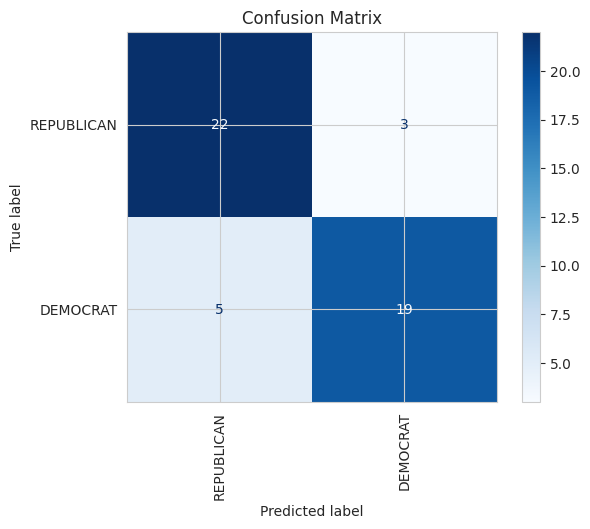

The overall predicted winner for 2020 is: DEMOCRAT

Electoral votes won by each party in 2020:
DEMOCRAT: 273 electoral votes
DEMOCRATIC-FARMER-LABOR: 10 electoral votes
REPUBLICAN: 252 electoral votes

The DEMOCRAT party won 22 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, FLORIDA, HAWAII, ILLINOIS, IOWA, MAINE, MARYLAND, MASSACHUSETTS, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OHIO, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The DEMOCRATIC-FARMER-LABOR party won 1 states. They are: MINNESOTA

The REPUBLICAN party won 27 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, GEORGIA, IDAHO, INDIANA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        

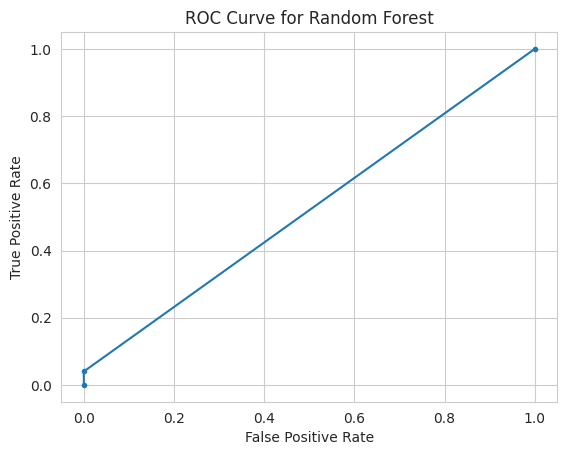

In [ ]:
# RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(clf_rf, 'Random Forest', X_train, y_train, X_test, y_test, test_data)

Logistic Regression



Accuracy: 0.90


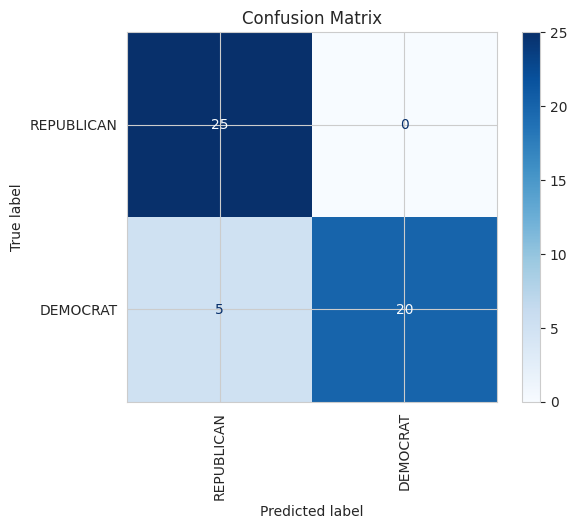

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 230 electoral votes
REPUBLICAN: 305 electoral votes

The DEMOCRAT party won 20 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The REPUBLICAN party won 30 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       1.00      0.80      0.89        25

    accuracy                           0.9

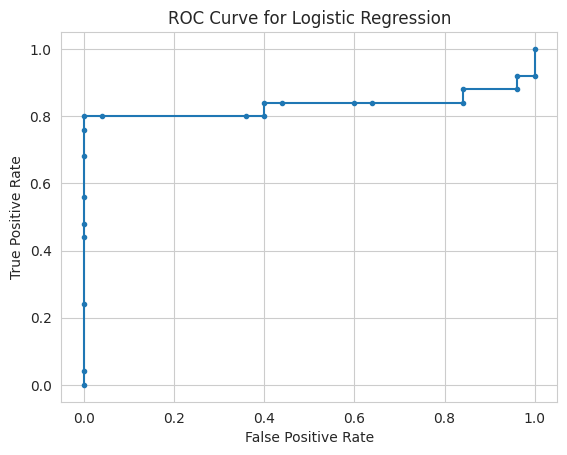

In [ ]:
# LogisticRegression with GridSearchCV (l1, l2 penalties)
clf_lr = LogisticRegression(random_state=42)
train_and_evaluate_model(clf_lr, 'Logistic Regression', X_train, y_train, X_test, y_test, test_data, param_grid_lr)

Gradient Boosting Classifier



Accuracy: 0.88


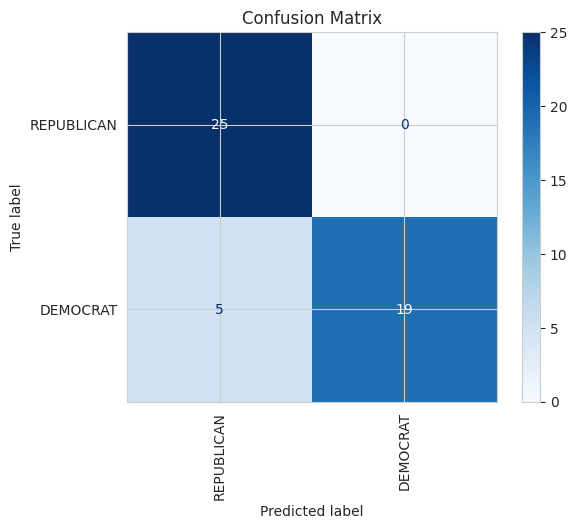

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 220 electoral votes
DEMOCRATIC-FARMER-LABOR: 10 electoral votes
REPUBLICAN: 305 electoral votes

The DEMOCRAT party won 19 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The DEMOCRATIC-FARMER-LABOR party won 1 states. They are: MINNESOTA

The REPUBLICAN party won 30 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      

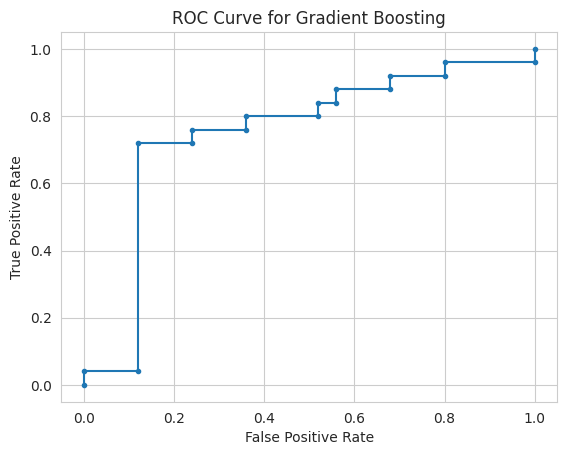

In [ ]:
# GradientBoostingClassifier with GridSearchCV
clf_gb = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(clf_gb, 'Gradient Boosting', X_train, y_train, X_test, y_test, test_data, param_grid_gb)

Support Vector Machine


Accuracy: 0.94


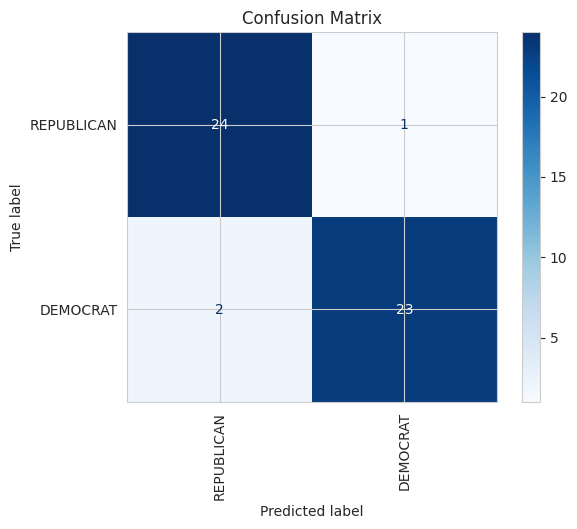

The overall predicted winner for 2020 is: DEMOCRAT

Electoral votes won by each party in 2020:
DEMOCRAT: 282 electoral votes
REPUBLICAN: 253 electoral votes

The DEMOCRAT party won 24 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, IOWA, MAINE, MARYLAND, MASSACHUSETTS, MICHIGAN, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, PENNSYLVANIA, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON, WISCONSIN

The REPUBLICAN party won 26 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, KANSAS, KENTUCKY, LOUISIANA, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WYOMING
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94 

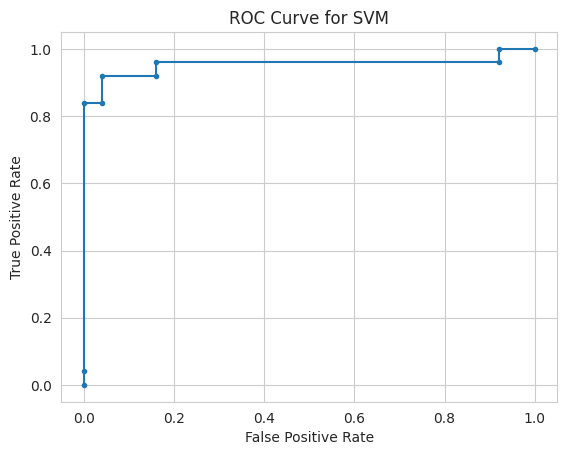

In [ ]:
# SVM
clf_svm = SVC(kernel='linear', random_state=42, probability=True)
train_and_evaluate_model(clf_svm, 'SVM', X_train, y_train, X_test, y_test, test_data)

Multi-Layer Perceptron Classifier (MLPC)



Accuracy: 0.74


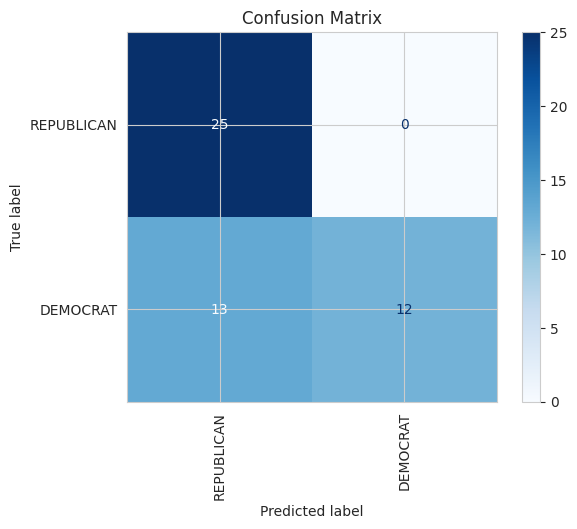

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 167 electoral votes
REPUBLICAN: 368 electoral votes

The DEMOCRAT party won 12 states. They are: CALIFORNIA, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEW JERSEY, NEW YORK, RHODE ISLAND, VERMONT

The REPUBLICAN party won 38 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, COLORADO, CONNECTICUT, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NEVADA, NEW HAMPSHIRE, NEW MEXICO, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, OREGON, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, VIRGINIA, WASHINGTON, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        25
           1       1.00      0.48      0.65        25

    accuracy                           0.7

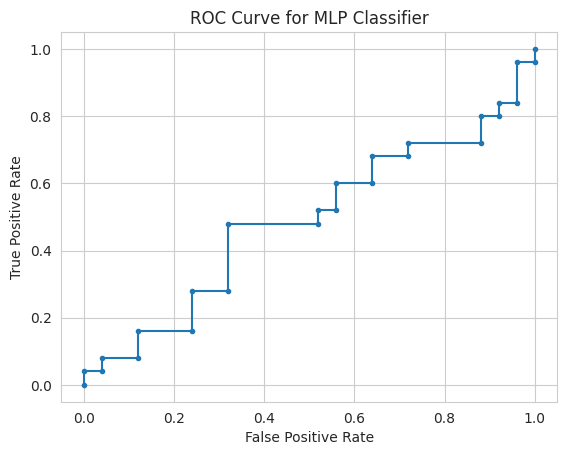

In [ ]:
# MLPClassifier with GridSearchCV
clf_mlp = MLPClassifier(random_state=42)
train_and_evaluate_model(clf_mlp, 'MLP Classifier', X_train, y_train, X_test, y_test, test_data, param_grid_mlp)

In [ ]:
# After evaluating all models, print the summary table
print("\nAUC ROC Summary Table:")
summary_df = pd.DataFrame(list(auc_scores.items()), columns=['Model', 'AUC ROC'])
print(summary_df)


AUC ROC Summary Table:
                 Model  AUC ROC
0        Random Forest   0.5200
1  Logistic Regression   0.8320
2    Gradient Boosting   0.7520
3                  SVM   0.9536
4       MLP Classifier   0.4880


# Predict 2024 Result
Random Forest and SVM were used because they predicted the correct Winning Party Democrat in the 2020 election even though Random Forest had a low AUC ROC.

In [ ]:
# Aggregate historical data
aggregated_data = modeling_df.groupby(['state', 'party_simplified']).agg(
    mean_totalvotes=pd.NamedAgg(column='totalvotes', aggfunc='mean'),
    std_totalvotes=pd.NamedAgg(column='totalvotes', aggfunc='std'),
    mean_candidatevotes=pd.NamedAgg(column='candidatevotes', aggfunc='mean'),
    std_candidatevotes=pd.NamedAgg(column='candidatevotes', aggfunc='std')
).reset_index()
print(aggregated_data.head())

     state party_simplified  mean_totalvotes  std_totalvotes  \
0  ALABAMA         DEMOCRAT     1.728156e+06   367584.926247   
1  ALABAMA      LIBERTARIAN     1.631145e+06   374086.243922   
2  ALABAMA            OTHER     1.598048e+06   329679.678281   
3  ALABAMA       REPUBLICAN     1.728156e+06   367584.926247   
4   ALASKA         DEMOCRAT     2.577378e+05    72812.535287   

   mean_candidatevotes  std_candidatevotes  
0        693703.333333        93756.759650  
1         13258.444444        13537.691560  
2         13959.764706        34249.928934  
3        984956.416667       297210.742557  
4         90471.666667        34730.163878  


In [ ]:
# Define parameters from aggregated data
parameters = aggregated_data.set_index(['state', 'party_simplified']).to_dict(orient='index')
# Number of synthetic records per state and party
num_records_per_state = 1
# Create synthetic data
synthetic_records = []
for (state, party), stats in parameters.items():
    mean_totalvotes = stats['mean_totalvotes']
    std_totalvotes = stats['std_totalvotes']
    mean_candidatevotes = stats['mean_candidatevotes']
    std_candidatevotes = stats['std_candidatevotes']
    # Generate synthetic totalvotes and candidatevotes
    totalvotes = np.random.normal(loc=mean_totalvotes, scale=std_totalvotes, size=num_records_per_state)
    candidatevotes = np.random.normal(loc=mean_candidatevotes, scale=std_candidatevotes, size=num_records_per_state)
    # Ensure non-negative votes and that candidatevotes do not exceed totalvotes
    for t_votes, c_votes in zip(totalvotes, candidatevotes):
        t_votes = max(int(t_votes), 0)
        c_votes = max(int(c_votes), 0)
        c_votes = min(c_votes, t_votes)  # Ensure candidatevotes does not exceed totalvotes
        synthetic_records.append({
            'state': state,
            'year': 2024,
            'candidatevotes': c_votes,
            'totalvotes': t_votes,
            'party_simplified': party
        })
# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_records)
print(synthetic_df.head())

     state  year  candidatevotes  totalvotes party_simplified
0  ALABAMA  2024          552773     2023469         DEMOCRAT
1  ALABAMA  2024            1908     1847670      LIBERTARIAN
2  ALABAMA  2024               0     1578253            OTHER
3  ALABAMA  2024          778876     1954349       REPUBLICAN
4   ALASKA  2024          130463      391880         DEMOCRAT


In [ ]:
# Combine historical data with synthetic 2024 data
combined_df = pd.concat([modeling_df, synthetic_df], ignore_index=True)
combined_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num,party_encoded,vote_percentage,winner
0,1976,ALABAMA,AL,1.0,63.0,41.0,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113.0,NaN,DEMOCRAT,22.0,0.0,55.727269,True
1,1976,ALABAMA,AL,1.0,63.0,41.0,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113.0,NaN,REPUBLICAN,22.0,3.0,42.614871,False
2,1976,ALABAMA,AL,1.0,63.0,41.0,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113.0,NaN,OTHER,22.0,2.0,0.777613,False
3,1976,ALABAMA,AL,1.0,63.0,41.0,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113.0,NaN,OTHER,22.0,2.0,0.563808,False
4,1976,ALABAMA,AL,1.0,63.0,41.0,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113.0,NaN,OTHER,22.0,2.0,0.165194,False


Random Forest - Predict 2024

In [ ]:
# Aggregate votes by party, state, and year
party_votes24 = combined_df.groupby(['year', 'state', 'party_simplified'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes24 = party_votes24.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes24['rank'] = party_votes24.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party24 = party_votes24[party_votes24['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table24 = winning_party24[['year', 'state', 'party_simplified']]
winner_table24.rename(columns={'party_simplified': 'winning_party'}, inplace=True)

# Calculate previous winning party
winner_table24['previous_winning_party'] = winner_table24.groupby('state')['winning_party'].shift(1)

# Merge winner table with electoral votes
winner_table24 = winner_table24.merge(electoral_votes_df, on='state', how='left')

# Prepare data for training (1976-2020) and testing (2024)
train_data24 = winner_table24[(winner_table24['year'] >= 1976) & (winner_table24['year'] <= 2020)]
test_data24 = winner_table24[winner_table24['year'] == 2024]

# Prepare the training data
X_train24 = train_data24[['year', 'state', 'previous_winning_party']]
y_train24 = train_data24['winning_party']

# Prepare data for a specific year to predict (e.g., 2024)
X_test24 = test_data24[['year', 'state', 'previous_winning_party']]
y_test24 = test_data24['winning_party']  # Actual labels for comparison

# Encode categorical features
X_train24 = pd.get_dummies(X_train24, columns=['state', 'previous_winning_party'])
X_test24 = pd.get_dummies(X_test24, columns=['state', 'previous_winning_party'])

# Ensure X_train and X_test have the same columns
X_test24 = X_test24.reindex(columns=X_train24.columns, fill_value=0)

In [ ]:
# RandomForestClassifier
clf_rf24 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf24.fit(X_train24, y_train24)

RandomForestClassifier(random_state=42)

Random Forest Accuracy: 0.60


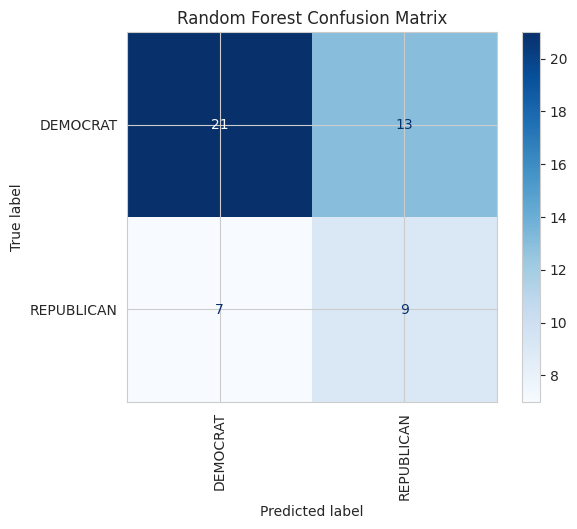

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        34
           1       0.41      0.56      0.47        16

    accuracy                           0.60        50
   macro avg       0.58      0.59      0.58        50
weighted avg       0.64      0.60      0.61        50

------------------------------------------------------------
ROC AUC Score for Random Forest: 0.33


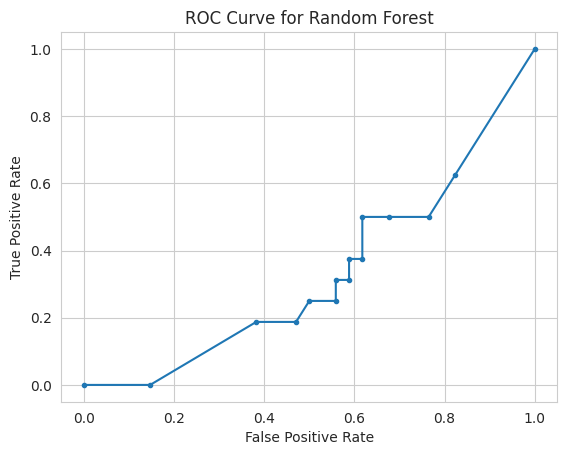

In [ ]:
# Predict on the test data
y_pred24_rf = clf_rf24.predict(X_test24)
y_prob24_rf = clf_rf24.predict_proba(X_test24)[:, 1]

# Map class labels to integers
label_mapping = {'DEMOCRAT': 1, 'REPUBLICAN': 0}
y_test24_numeric = y_test24.map(label_mapping)
y_pred24_numeric = pd.Series(y_pred24_rf).map(label_mapping)

# Calculate accuracy
accuracy24 = accuracy_score(y_test24_numeric, y_pred24_numeric)
print(f'Random Forest Accuracy: {accuracy24:.2f}')

# Plot the confusion matrix
cm24 = confusion_matrix(y_test24_numeric, y_pred24_numeric)
disp = ConfusionMatrixDisplay(confusion_matrix=cm24, display_labels=list(label_mapping.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Print classification report
class_report24 = classification_report(y_test24_numeric, y_pred24_numeric)
print('Classification Report for Random Forest:')
print(class_report24)
print('-' * 60)

# Compute ROC AUC score
if len(np.unique(y_test24_numeric)) == 2:  # Check if binary classification
    auc24 = roc_auc_score(y_test24_numeric, y_prob24_rf)
    print(f'ROC AUC Score for Random Forest: {auc24:.2f}')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test24_numeric, y_prob24_rf)
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest')
    plt.show()

In [ ]:
# Create DataFrame with predictions
test_predictions_2024 = pd.DataFrame(X_test24.copy())
test_predictions_2024['predicted_winning_party'] = y_pred24_rf
test_predictions_2024['state'] = test_data24['state'].values
test_predictions_2024['electoral_votes'] = test_data24['electoral_votes'].values

# Aggregate electoral college votes by predicted winning party
electoral_votes_by_party_2024 = test_predictions_2024.groupby('predicted_winning_party')['electoral_votes'].sum()
overall_winner = electoral_votes_by_party_2024.idxmax()
print(f'The overall predicted winner for 2024 is: {overall_winner}')

print("\nElectoral votes that will be won by each party in 2024:")
for party, votes in electoral_votes_by_party_2024.items():
    print(f"{party}: {votes} electoral votes")

# Display states won by each party
for party in electoral_votes_by_party_2024.index:
    states_won = test_predictions_2024[test_predictions_2024['predicted_winning_party'] == party]['state'].tolist()
    print(f"\nThe {party} party will win {len(states_won)} states. They are: {', '.join(states_won)}")

The overall predicted winner for 2024 is: REPUBLICAN

Electoral votes won by each party in 2024:
DEMOCRAT: 257 electoral votes
REPUBLICAN: 278 electoral votes

The DEMOCRAT party won 22 states. They are: ARIZONA, CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, GEORGIA, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The REPUBLICAN party won 28 states. They are: ALABAMA, ALASKA, ARKANSAS, FLORIDA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING


Support Vector Machine - Predict 2024

In [ ]:
# Aggregate votes by party, state, and year
party_votes24 = combined_df.groupby(['year', 'state', 'party_simplified'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes24 = party_votes24.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes24['rank'] = party_votes24.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party24 = party_votes24[party_votes24['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table24 = winning_party24[['year', 'state', 'party_simplified']]
winner_table24.rename(columns={'party_simplified': 'winning_party'}, inplace=True)

# Calculate previous winning party
winner_table24['previous_winning_party'] = winner_table24.groupby('state')['winning_party'].shift(1)

# Merge winner table with electoral votes
winner_table24 = winner_table24.merge(electoral_votes_df, on='state', how='left')

# Prepare data for training (1976-2020) and testing (2024)
train_data24 = winner_table24[(winner_table24['year'] >= 1976) & (winner_table24['year'] <= 2020)]
test_data24 = winner_table24[winner_table24['year'] == 2024]

# Prepare the training data
X_train24 = train_data24[['year', 'state', 'previous_winning_party']]
y_train24 = train_data24['winning_party']

# Prepare data for a specific year to predict (e.g., 2024)
X_test24 = test_data24[['year', 'state', 'previous_winning_party']]
y_test24 = test_data24['winning_party']  # Actual labels for comparison

# Encode categorical features
X_train24 = pd.get_dummies(X_train24, columns=['state', 'previous_winning_party'])
X_test24 = pd.get_dummies(X_test24, columns=['state', 'previous_winning_party'])

# Ensure X_train and X_test have the same columns
X_test24 = X_test24.reindex(columns=X_train24.columns, fill_value=0)

In [ ]:
# SVM
clf_svm24 = SVC(kernel='linear', random_state=42, probability=True)
clf_svm24.fit(X_train24, y_train24)

SVC(kernel='linear', probability=True, random_state=42)

SVM Accuracy: 0.64


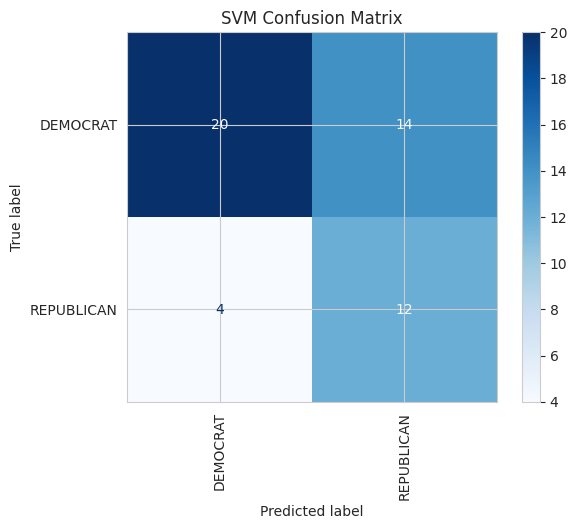

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        34
           1       0.46      0.75      0.57        16

    accuracy                           0.64        50
   macro avg       0.65      0.67      0.63        50
weighted avg       0.71      0.64      0.65        50

------------------------------------------------------------
ROC AUC Score for SVM: 0.30


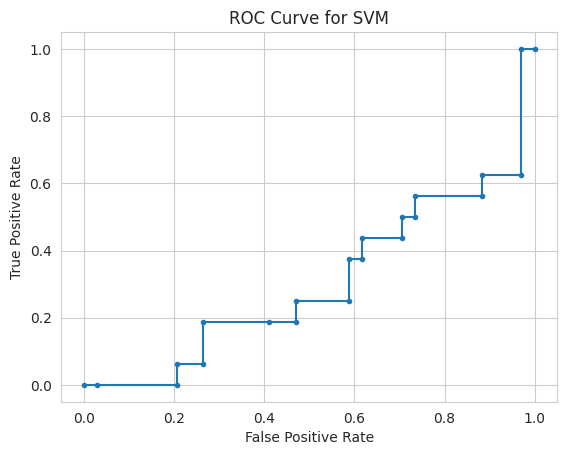

In [ ]:
# Predict on the test data
y_pred24_svm = clf_svm24.predict(X_test24)
y_prob24_svm = clf_svm24.predict_proba(X_test24)[:, 1]  # Probability estimates for ROC AUC

# Map class labels to integers
label_mapping = {'DEMOCRAT': 1, 'REPUBLICAN': 0}
y_test24_numeric_svm = y_test24.map(label_mapping)
y_pred24_numeric_svm = pd.Series(y_pred24_svm).map(label_mapping)

# Calculate accuracy
accuracy24_svm = accuracy_score(y_test24_numeric_svm, y_pred24_numeric_svm)
print(f'SVM Accuracy: {accuracy24_svm:.2f}')

# Plot the confusion matrix
cm24_svm = confusion_matrix(y_test24_numeric_svm, y_pred24_numeric_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm24_svm, display_labels=list(label_mapping.keys()))
disp_svm.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('SVM Confusion Matrix')
plt.show()

# Print classification report
class_report24_svm = classification_report(y_test24_numeric_svm, y_pred24_numeric_svm)
print('Classification Report for SVM:')
print(class_report24_svm)
print('-' * 60)

# Compute ROC AUC score
if len(np.unique(y_test24_numeric_svm)) == 2:  # Check if binary classification
    auc24_svm = roc_auc_score(y_test24_numeric_svm, y_prob24_svm)
    print(f'ROC AUC Score for SVM: {auc24_svm:.2f}')

    # Plot ROC Curve
    fpr_svm, tpr_svm, _ = roc_curve(y_test24_numeric_svm, y_prob24_svm)
    plt.plot(fpr_svm, tpr_svm, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SVM')
    plt.show()

In [ ]:
# Create DataFrame with predictions
test_predictions_2024_svm = pd.DataFrame(X_test24.copy())
test_predictions_2024_svm['predicted_winning_party'] = y_pred24_svm
test_predictions_2024_svm['state'] = test_data24['state'].values
test_predictions_2024_svm['electoral_votes'] = test_data24['electoral_votes'].values

# Aggregate electoral college votes by predicted winning party
electoral_votes_by_party_2024_svm = test_predictions_2024_svm.groupby('predicted_winning_party')['electoral_votes'].sum()
overall_winner_svm = electoral_votes_by_party_2024_svm.idxmax()
print(f'The overall predicted winner for 2024 is: {overall_winner_svm}')

print("\nElectoral votes that will be won by each party in 2024:")
for party, votes in electoral_votes_by_party_2024_svm.items():
    print(f"{party}: {votes} electoral votes")

# Display states won by each party
for party in electoral_votes_by_party_2024_svm.index:
    states_won = test_predictions_2024_svm[test_predictions_2024_svm['predicted_winning_party'] == party]['state'].tolist()
    print(f"\nThe {party} party will win {len(states_won)} states. They are: {', '.join(states_won)}")

The overall predicted winner for 2024 is: DEMOCRAT

Electoral votes that will be won by each party in 2024:
DEMOCRAT: 309 electoral votes
REPUBLICAN: 226 electoral votes

The DEMOCRAT party will win 26 states. They are: ARIZONA, CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, GEORGIA, HAWAII, ILLINOIS, IOWA, MAINE, MARYLAND, MASSACHUSETTS, MICHIGAN, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, PENNSYLVANIA, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON, WISCONSIN

The REPUBLICAN party will win 24 states. They are: ALABAMA, ALASKA, ARKANSAS, FLORIDA, IDAHO, INDIANA, KANSAS, KENTUCKY, LOUISIANA, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WYOMING
